In [1]:
!pip install -r requirements.txt

  Using cached torch-2.9.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cusolver_cu12-11.7.3.90-py3-none-manylinux_2_27_x86_64.whl.metadat

In [2]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
import re
from transformers import pipeline
import random
import matplotlib.pyplot as plt

In [3]:
# 1. 데이터셋 로드 

print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

# 클래스 라벨 정의 (AG News 기준)
# 0: World, 1: Sports, 2: Business, 3: Sci/Tech
labels = ["World", "Sports", "Business", "Sci/Tech"]

test_dataset = dataset['test'].shuffle(seed=42).select(range(1000))

print(f"Test data size: {len(test_dataset)}")
print(f"Example data: {test_dataset[0]}")

Loading AG News dataset...
Test data size: 1000
Example data: {'text': 'Indian board plans own telecast of Australia series The Indian cricket board said on Wednesday it was making arrangements on its own to broadcast next month #39;s test series against Australia, which is under threat because of a raging TV rights dispute.', 'label': 1}


In [4]:
# 1. 데이터셋 전처리

def preprocess_text(data):
    text = data['text']
    # 1. 소문자 변환
    text = text.lower()
    
    # 2. 불필요한 특수문자 제거 (정규표현식 사용)
    # 알파벳, 숫자, 공백만 남기고 다 제거
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # 3. 다중 공백 제거 (공백이 여러 개면 하나로 줄임)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return {"text": text, "label": data['label']}


print("Applying preprocessing...")

test_dataset = test_dataset.map(preprocess_text)

print(f"Preprocessed Example: {test_dataset[0]['text']}")

Applying preprocessing...
Preprocessed Example: indian board plans own telecast of australia series the indian cricket board said on wednesday it was making arrangements on its own to broadcast next month 39s test series against australia which is under threat because of a raging tv rights dispute


In [5]:
# 2. 나이브 베이스라인 (Keyword-based Classifier)

def naive_baseline(text):
    text = text.lower()
    
    # 각 카테고리별 대표 키워드 정의 (단순 규칙)
    keywords = {
        0: ["war", "president", "minister", "politic", "country", "police", "gov", "crime", "world"],         # World
        1: ["game", "cup", "team", "score", "win", "season", "olympic", "defeat", "sports"],                  # Sports
        2: ["stock", "market", "company", "price", "profit", "corp", "bank", "econom", "business"],           # Business
        3: ["computer", "software", "microsoft", "internet", "space", "chip", "service","science", "tech"]    # Sci/Tech
    }
    
    # 키워드 매칭 점수 계산
    scores = {0: 0, 1: 0, 2: 0, 3: 0}
    for label, words in keywords.items():
        for word in words:
            if word in text:
                scores[label] += 1
    
    # 가장 점수가 높은 클래스 선택 (동점이면 후보들 중에서 무작위로 하나 선택)
    max_score = max(scores.values())
    
    candidates = [label for label, score in scores.items() if score == max_score]
    
    pred = random.choice(candidates)
    
    return pred

In [6]:
# 3. AI 파이프라인 구성 (Pre-trained Model)

# AG News에 대해 이미 학습된 모델 사용 (Fine-tuning 불필요)
model_name = "fabriceyhc/bert-base-uncased-ag_news"

print(f"\nLoading AI Pipeline with model: {model_name}...")

# 파이프라인 생성 (자동으로 토크나이저와 모델을 로드함)
classifier = pipeline("text-classification", model=model_name, tokenizer=model_name, truncation=True)


Loading AI Pipeline with model: fabriceyhc/bert-base-uncased-ag_news...


Device set to use cuda:0


In [7]:
# 4. baseline test
print("\nRunning Naive Baseline...")
baseline_preds = [naive_baseline(item['text']) for item in test_dataset]

# 5. ai test
print("Running AI Pipeline...")

# 데이터에서 텍스트만 추출
texts = test_dataset['text']

# 파이프라인을 통해 예측 수행
ai_results = classifier(list(texts))

# 결과 변환 (모델 출력인 LABEL_0, World 등을 정수 인덱스 0, 1, 2, 3으로 변환)
# 이 모델은 라벨을 "World", "Sports" 등으로 출력함. 이를 정수로 매핑해야 함.
label_map = {"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}

ai_preds = []
for result in ai_results:
    # 모델이 출력한 라벨 스트링을 정수로 변환
    pred_label_str = result['label']
    ai_preds.append(int(pred_label_str.split("_")[-1]))


Running Naive Baseline...
Running AI Pipeline...



=== Baseline Accuracy: 0.531 ===
              precision    recall  f1-score   support

       World      0.527     0.523     0.525       266
      Sports      0.607     0.703     0.652       246
    Business      0.496     0.537     0.516       246
    Sci/Tech      0.470     0.360     0.407       242

    accuracy                          0.531      1000
   macro avg      0.525     0.530     0.525      1000
weighted avg      0.525     0.531     0.525      1000


=== AI Pipeline Accuracy: 0.897 ===
              precision    recall  f1-score   support

       World      0.938     0.857     0.896       266
      Sports      0.932     0.996     0.963       246
    Business      0.842     0.890     0.866       246
    Sci/Tech      0.876     0.847     0.861       242

    accuracy                          0.897      1000
   macro avg      0.897     0.898     0.896      1000
weighted avg      0.898     0.897     0.897      1000


f1_score_comparison_line_chart_dynamic_final.png 파일이 저장되었습

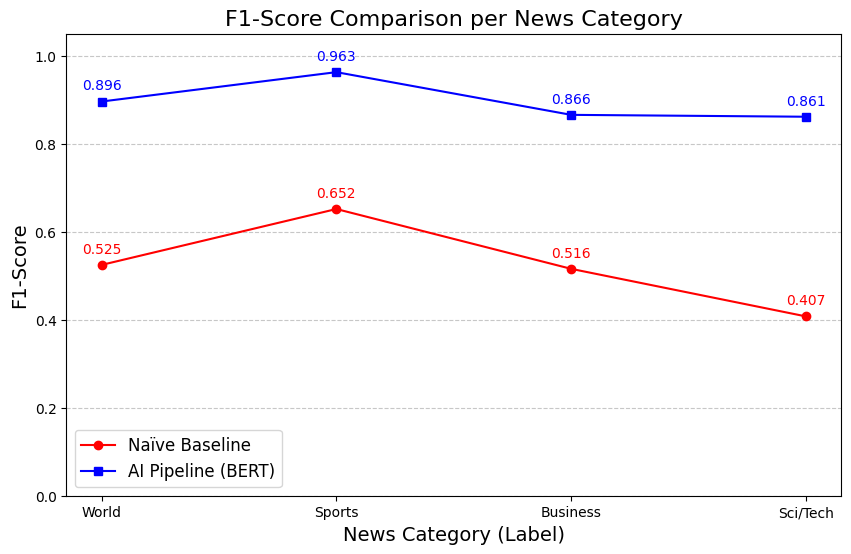

In [12]:
# 6. Evaluation

ground_truth = test_dataset['label'] 

# --- 1. 베이스라인 평가 및 F1 스코어 동적 추출 ---
baseline_acc = accuracy_score(ground_truth, baseline_preds)
print(f"\n=== Baseline Accuracy: {baseline_acc:.3f} ===")

baseline_report_dict = classification_report(
    ground_truth, baseline_preds, target_names=labels, output_dict=True, digits=3
)
print(classification_report(ground_truth, baseline_preds, target_names=labels, digits=3))

# F1 스코어 동적 추출
baseline_f1 = {label: baseline_report_dict[label]['f1-score'] for label in labels}


# --- 2. AI 파이프라인 평가 및 F1 스코어 동적 추출 ---
ai_acc = accuracy_score(ground_truth, ai_preds)
print(f"\n=== AI Pipeline Accuracy: {ai_acc:.3f} ===")

ai_report_dict = classification_report(
    ground_truth, ai_preds, target_names=labels, output_dict=True, digits=3
)
print(classification_report(ground_truth, ai_preds, target_names=labels, digits=3))

# F1 스코어 동적 추출
ai_f1 = {label: ai_report_dict[label]['f1-score'] for label in labels}


# --- 3. 꺾은선 그래프 생성 ---
plot_data = pd.DataFrame({
    'Baseline (F1)': baseline_f1,
    'AI Pipeline (F1)': ai_f1
}).T

plt.figure(figsize=(10, 6))

plt.plot(plot_data.columns, plot_data.loc['Baseline (F1)'], 
          marker='o', linestyle='-', color='red', label='Naïve Baseline')
plt.plot(plot_data.columns, plot_data.loc['AI Pipeline (F1)'], 
          marker='s', linestyle='-', color='blue', label='AI Pipeline (BERT)')

# 그래프 제목 및 레이블 설정
plt.title('F1-Score Comparison per News Category', fontsize=16)
plt.xlabel('News Category (Label)', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)

# Y축 범위 설정
plt.ylim(0.0, 1.05)

# 범례 표시
plt.legend(fontsize=12)

# 격자 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 데이터 포인트 값 표시 (F1 스코어 변수에서 동적으로 값을 가져옴)
for i, label in enumerate(plot_data.columns):
    # Baseline 값 표시
    plt.text(i, plot_data.loc['Baseline (F1)', label] + 0.02, 
              f"{plot_data.loc['Baseline (F1)', label]:.3f}", # .3f로 소수점 3자리 표시
              ha='center', va='bottom', color='red')
    
    # AI Pipeline 값 표시
    plt.text(i, plot_data.loc['AI Pipeline (F1)', label] + 0.02, 
              f"{plot_data.loc['AI Pipeline (F1)', label]:.3f}", # .3f로 소수점 3자리 표시
              ha='center', va='bottom', color='blue')

# 그래프 저장
plt.savefig('f1_score_comparison_line_chart_dynamic_final.png')
print("\nf1_score_comparison_line_chart_dynamic_final.png 파일이 저장되었습니다. (F1 스코어 동적 추출)")

In [11]:
# 7. Analysis
# 베이스라인은 틀렸지만, AI는 정답을 맞춘 케이스 찾기

print("\n=== Finding Real Comparison Cases (Baseline: X | AI: O) ===\n")

count = 0
target_count = 50  # 찾고 싶은 예시 개수

# 전체 테스트 데이터(1000개)를 순회하며 조건에 맞는 것 찾기
for i in range(len(test_dataset)):
    true_label_idx = ground_truth[i]
    base_pred_idx = baseline_preds[i]
    ai_pred_idx = ai_preds[i]
    
    # 조건: 베이스라인은 틀리고 AND AI는 맞았을 때
    if base_pred_idx != true_label_idx and ai_pred_idx == true_label_idx:
        
        # 텍스트 가져오기
        text_content = test_dataset[i]['text']
        
        # 출력 (보고서에 쓰기 좋게 포맷팅)
        print(f"[Case #{count + 1}]")
        print(f"Text: \"{text_content}\"")
        print(f"• True Label: {labels[true_label_idx]}")
        print(f"• Baseline Prediction: {labels[base_pred_idx]} (Failed)")
        print(f"• AI Pipeline Prediction: {labels[ai_pred_idx]} (Correct)")
        print("-" * 50)
        
        count += 1
        if count >= target_count:
            break

if count == 0:
    print("조건에 맞는 케이스를 찾지 못했습니다. (베이스라인이 너무 잘했거나 AI가 못했거나)")


=== Finding Real Comparison Cases (Baseline: X | AI: O) ===

[Case #1]
Text: "indian board plans own telecast of australia series the indian cricket board said on wednesday it was making arrangements on its own to broadcast next month 39s test series against australia which is under threat because of a raging tv rights dispute"
• True Label: Sports
• Baseline Prediction: Business (Failed)
• AI Pipeline Prediction: Sports (Correct)
--------------------------------------------------
[Case #2]
Text: "adv try currency trading riskfree 30 days 24hour commissionfree trading 100to1 leverage of your capital and dealbook fx 2 our free advanced trading software sign up for our free 30day trial and receive oneonone training"
• True Label: Business
• Baseline Prediction: Sci/Tech (Failed)
• AI Pipeline Prediction: Business (Correct)
--------------------------------------------------
[Case #3]
Text: "opec can raise output capacity by 1 mln barrelsday update1 the organization of petroleum exporting